Changelog:  (Last Updated 2024-03-04)

*



# Probabilistic ML: Assignment 3 (start early!)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $A$ beats player $B$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent, given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b22aeea7714eb65692ef81d75c9d2c347b6cb3ab0cb24e8570f5158df54ab83c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b`, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [10pts]** Implement the missing lines in the code below, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.

    epsilon = torch.randn(num_samples, mean.shape[0])

    return mean + torch.exp(log_std) * epsilon


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)

    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    t = diag_gaussian_samples(mean, log_std, num_samples)
    log_qt = diag_gaussian_logpdf(t, mean, log_std)
    log_prob_xt = logprob(t)

    elbo = torch.mean(log_prob_xt - log_qt)

    return elbo


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  return - batch_elbo(log_posterior_A_beat_B_10_times_1_arg, params[0], params[1],
                      num_samples_per_iter)

**c) [2pts]** Initialize a set of variational parameters and optimize them (written for you already) to approximate the joint distribution where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  0%|          | 1/800 [00:00<01:59,  6.70it/s]

Iteration 0 lower bound 9.503812789916992


  7%|▋         | 54/800 [00:00<00:02, 262.22it/s]

Iteration 25 lower bound 6.416818618774414
Iteration 50 lower bound 6.176743984222412
Iteration 75 lower bound 6.511999130249023
Iteration 100 lower bound 6.120234966278076


 13%|█▎        | 103/800 [00:00<00:01, 351.68it/s]

Iteration 125 lower bound 5.115118503570557


 27%|██▋       | 216/800 [00:00<00:01, 476.49it/s]

Iteration 150 lower bound 4.765292167663574
Iteration 175 lower bound 4.824062347412109
Iteration 200 lower bound 4.150511741638184
Iteration 225 lower bound 4.076598644256592
Iteration 250 lower bound 3.0558829307556152


 40%|███▉      | 319/800 [00:00<00:00, 491.75it/s]

Iteration 275 lower bound 3.415905714035034
Iteration 300 lower bound 3.270498275756836
Iteration 325 lower bound 3.0462090969085693
Iteration 350 lower bound 3.220257520675659


 47%|████▋     | 373/800 [00:00<00:00, 506.61it/s]

Iteration 375 lower bound 3.1044416427612305


 60%|██████    | 482/800 [00:01<00:00, 524.86it/s]

Iteration 400 lower bound 3.143667221069336
Iteration 425 lower bound 2.8828368186950684
Iteration 450 lower bound 3.0135202407836914
Iteration 475 lower bound 3.0495004653930664
Iteration 500 lower bound 3.0635006427764893


 74%|███████▎  | 589/800 [00:01<00:00, 528.49it/s]

Iteration 525 lower bound 2.9302916526794434
Iteration 550 lower bound 2.939755439758301
Iteration 575 lower bound 2.952504873275757
Iteration 600 lower bound 2.8165106773376465


 88%|████████▊ | 700/800 [00:01<00:00, 523.74it/s]

Iteration 625 lower bound 3.0578818321228027
Iteration 650 lower bound 2.8602728843688965
Iteration 675 lower bound 2.976090669631958
Iteration 700 lower bound 2.906651496887207
Iteration 725 lower bound 2.854100227355957


100%|██████████| 800/800 [00:01<00:00, 480.89it/s]


Iteration 750 lower bound 2.8329172134399414
Iteration 775 lower bound 2.9146158695220947


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


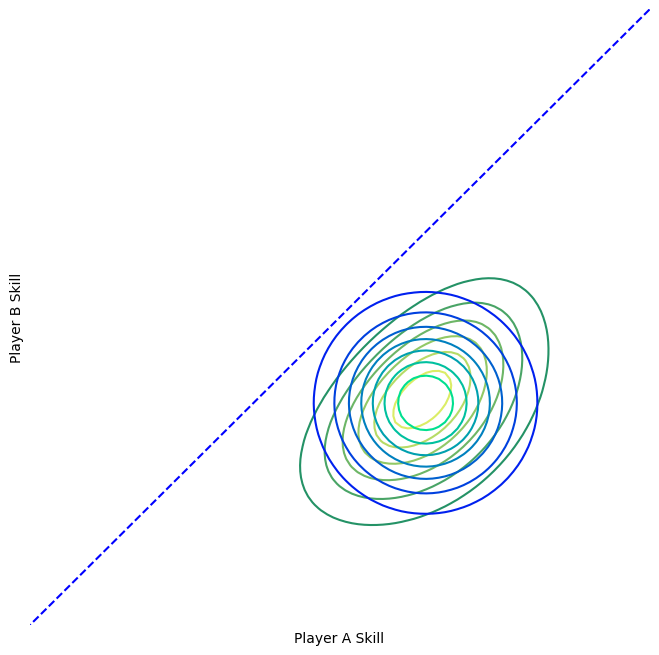

<Figure size 640x480 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
# We need two variational parameters
init_log_std  = torch.zeros(D, requires_grad=True)
init_mean = torch.zeros(D, requires_grad=True)

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

In [ ]:
callback(params, n_iters)

Iteration 800 lower bound 2.940080165863037


The loss is about 2.9401.

**d) [2pts]** Write a loss function called $\texttt{objective}$  that takes the variational distribution parameters, and returns a negative ELBO estimate using simple Monte Carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint distribution where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)

    return log_posterior_beat_each_other_10_times(z1z2[:,0], z1z2[:,1]).flatten()


def objective(params):
    return - batch_elbo(log_posterior_beat_each_other_10_times_1_arg, params[0],
                        params[1], num_samples_per_iter)

**e) [2pts]** Run the code below to optimize the parameters, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

---

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


100%|██████████| 100/100 [00:00<00:00, 514.83it/s]

Iteration 0 lower bound 17.743330001831055
Iteration 25 lower bound 17.960617065429688
Iteration 50 lower bound 17.526962280273438
Iteration 75 lower bound 16.898731231689453


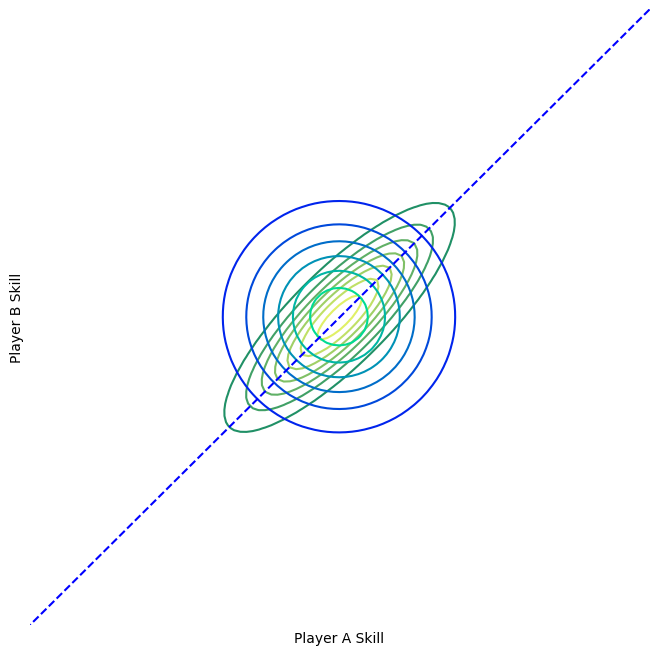

<Figure size 640x480 with 0 Axes>

In [ ]:
# Main loop.
# Reinitialize with the same initialization as you did in 1c) .
init_mean = torch.zeros(D, requires_grad=True)
init_log_std = torch.zeros(D, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

In [ ]:
callback(params, n_iters)

Iteration 100 lower bound 16.1069393157959


The loss is about 16.1069.


The true poesterior is more concentrated along the line of equal skill, so it is plausible that the skills of two players are at the same level under the true posterior, which are less plausible under the approximate posterior.

Changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian will make a better approximation because it is likely that the skills of the two players are correlated given the true posterior.

## 1.2 [30pts] Approximate inference conditioned on real data

The dataset contains data on 2546 chess games amongst 1434 players:
 - 'names' is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - 'games' is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column of 'games' contains the indices of the players who won.
The second column of 'games' contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [ ]:
# wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
# games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
# wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
# names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()


wget.download("https://vahidbalazadeh.me/assets/datasets/chess_players.csv")
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_id", "loser_id"]].to_numpy()
names = pd.read_csv("chess_players.csv")[["player_name"]].to_numpy().astype('str')


games = torch.LongTensor(games)

In [ ]:
games.shape

torch.Size([2543, 2])

In [ ]:
names.shape

(1163, 1)



**a) [0pts]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ below takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills. (You do not need to code anything here.)

In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [2pts]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [ ]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    return - batch_elbo(log_joint_probability, params[0], params[1],
                       num_samples_per_iter)

**c) [2pts]** Optimize, and report the final loss.

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


callback(params, n_iters)

Optimizing variational parameters...


  1%|          | 3/500 [00:00<00:16, 29.27it/s]

Iteration 0 lower bound 2295.192138671875


  6%|▋         | 32/500 [00:00<00:12, 38.95it/s]

Iteration 25 lower bound 2191.218505859375


 11%|█         | 55/500 [00:01<00:11, 39.05it/s]

Iteration 50 lower bound 2080.78955078125


 16%|█▌        | 80/500 [00:02<00:10, 39.31it/s]

Iteration 75 lower bound 1998.1466064453125


 21%|██        | 106/500 [00:02<00:10, 38.34it/s]

Iteration 100 lower bound 1933.2083740234375


 27%|██▋       | 135/500 [00:03<00:08, 41.57it/s]

Iteration 125 lower bound 1881.0860595703125


 31%|███       | 155/500 [00:03<00:08, 41.23it/s]

Iteration 150 lower bound 1840.218505859375


 36%|███▌      | 180/500 [00:04<00:08, 38.81it/s]

Iteration 175 lower bound 1803.7078857421875


 41%|████▏     | 207/500 [00:05<00:07, 39.97it/s]

Iteration 200 lower bound 1773.514404296875


 46%|████▌     | 231/500 [00:05<00:06, 39.34it/s]

Iteration 225 lower bound 1749.9483642578125


 51%|█████     | 256/500 [00:06<00:06, 37.51it/s]

Iteration 250 lower bound 1723.4456787109375


 56%|█████▌    | 281/500 [00:07<00:06, 34.09it/s]

Iteration 275 lower bound 1709.1845703125


 61%|██████    | 305/500 [00:08<00:07, 26.27it/s]

Iteration 300 lower bound 1697.08251953125


 66%|██████▌   | 329/500 [00:08<00:06, 26.00it/s]

Iteration 325 lower bound 1680.9918212890625


 72%|███████▏  | 358/500 [00:09<00:04, 33.21it/s]

Iteration 350 lower bound 1666.35791015625


 77%|███████▋  | 383/500 [00:10<00:03, 36.53it/s]

Iteration 375 lower bound 1654.5172119140625


 81%|████████  | 406/500 [00:11<00:02, 38.38it/s]

Iteration 400 lower bound 1648.3697509765625


 86%|████████▋ | 432/500 [00:11<00:01, 37.29it/s]

Iteration 425 lower bound 1637.48046875


 92%|█████████▏| 458/500 [00:12<00:01, 37.17it/s]

Iteration 450 lower bound 1629.30224609375


 96%|█████████▌| 480/500 [00:13<00:00, 37.65it/s]

Iteration 475 lower bound 1624.5118408203125


100%|██████████| 500/500 [00:13<00:00, 36.57it/s]

Iteration 500 lower bound 1617.209716796875


In [ ]:
callback(params, n_iters)

Iteration 500 lower bound 1616.0743408203125


The final loss is about 1616.0743.

**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

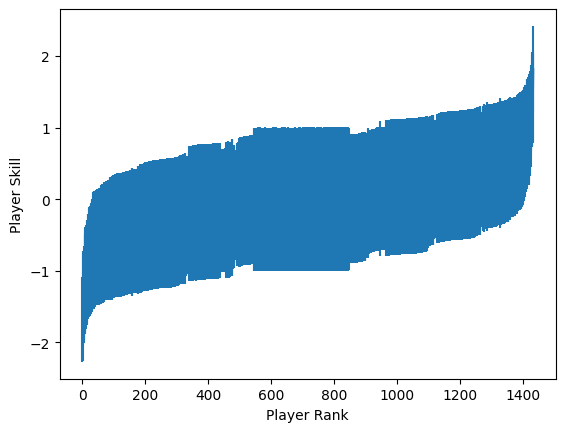

In [ ]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], torch.exp(logstd_skills)[order])

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [ ]:
print('The 10 players with highest mean skills:')
for i in range(1, 11):
  print(names[order[-i]])

The 10 players with highest mean skills:
['doraemon61']
['smartduckduckcow']
['projetoxadrez']
['mrzoom47']
['chesswithmom']
['lance5500']
['lzchips']
['chess-brahs']
['cdvh']
['chiggen']


**f) [3pt]** Plot samples from the joint posterior over the skills of 'lelik3310' and 'thebestofthebad'. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

['lelik3310']
['thebestofthebad']


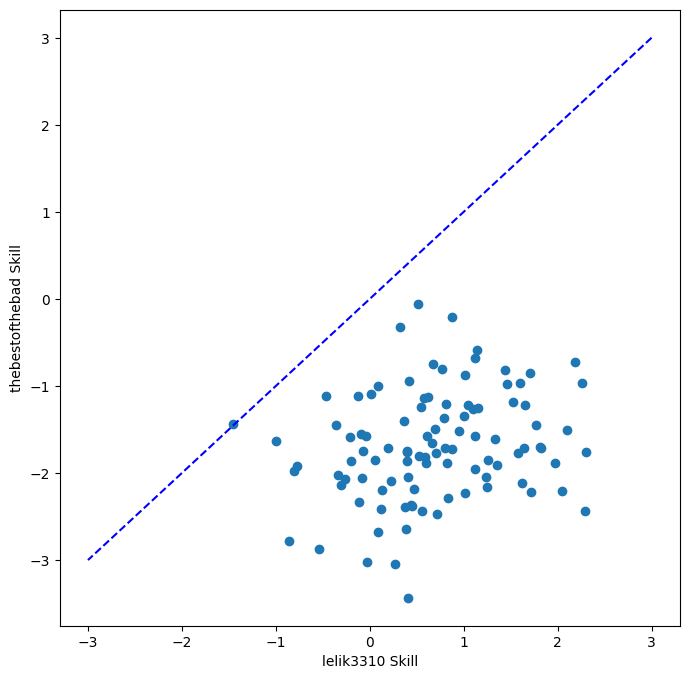

In [ ]:
lelik3310_ix = np.where(names == "lelik3310")[0][0]
thebestofthebad_ix = np.where(names == "thebestofthebad")[0][0]
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill")
plt.ylabel("thebestofthebad Skill")

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
plt.scatter(samples[:, lelik3310_ix], samples[:, thebestofthebad_ix])

Given that our sample is mostly at the right side of the line of equal skill, it is more likely that the skill of lelik3310 is better.

**g) [6pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^\top)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

Your answer here.

Given two players A and B, say that we want to derive the exact probability that A has higher skill than B. We first consider the linear transformation $y_A, y_B = z_A − z_B , z_B$.

The line of equal skill before transformation is $z_A = z_B$. After applying the transformation, it can be also written as:
$$y_A + y_B = y_B$$
$$y_A = 0$$

Therefore, the probability we want can be also written as:

$$P(z_A > z_B) = P(y_A > 0)$$

Write the linear transformation in the matrix form:

\begin{align}
    \begin{bmatrix}
    y_A\\
    y_B
    \end{bmatrix}
    \
    = \begin{bmatrix}
      1 & -1\\
      0 & 1
    \end{bmatrix}
    \
    \begin{bmatrix}
      z_A \\
      z_B
    \end{bmatrix}
 \end{align}

 Based on $X \sim  N (\mu, \Sigma)$, then $AX \sim N (A\mu, A\Sigma A^\top),$

\begin{align}
    \begin{bmatrix}
    y_A\\
    y_B
    \end{bmatrix}
    \sim N(
    \begin{bmatrix}
      1 & -1\\
      0 & 1
    \end{bmatrix}
    \
    \begin{bmatrix}
      \mu_A \\
      \mu_B
    \end{bmatrix},
    \begin{bmatrix}
      1 & -1\\
      0 & 1
    \end{bmatrix}
    \begin{bmatrix}
      \sigma^2_A & 0\\
      0 & \sigma^2_B
    \end{bmatrix}
    \begin{bmatrix}
      1 & 0\\
      -1 & 1
    \end{bmatrix}
    )
 \end{align}

 \begin{align}
    \begin{bmatrix}
    y_A\\
    y_B
    \end{bmatrix}
    \sim N(
    \begin{bmatrix}
      \mu_A - \mu_B \\
      \mu_B
    \end{bmatrix},
    \begin{bmatrix}
      \sigma^2_A + \sigma^2_B & - \sigma^2_B\\
      -\sigma^2_B & \sigma^2_B
    \end{bmatrix}
    )
 \end{align}


Then we perform marginalization and obtain the marginal distribution of $y_A \sim N (\mu_A - \mu_B ,  \sigma^2_A + \sigma^2_B)$

Therefore, we can compute the exact probability:
$$P(z_A > z_B) = P(y_A > 0) = 1 - P(y_A ≤ 0)$$
$$= 1 - \Phi(\frac{\mu_B - \mu_A}{\sqrt{\sigma^2_A + \sigma^2_B}})$$

**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    mean_A = samples[:, A_ix].mean()
    mean_B = samples[:, B_ix].mean()

    var_A = samples[:, A_ix].var()
    var_B = samples[:, B_ix].var()
    formula_est = 1 - Normal(0, 1).cdf((mean_B - mean_A) / torch.sqrt(var_A + var_B))

    mc_samples = diag_gaussian_samples(mean_skills, logstd_skills, N)
    mc_est = (mc_samples[:, A_ix] > mc_samples[:, B_ix]).float().mean()

    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9904594421386719
Simple MC Estimate: 0.9883999824523926


**i) [3pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
fifth_worst_ix = order[4]
formula_est_1, mc_est_1 = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)

print(f"Exact CDF Estimate: {formula_est_1}")
print(f"Simple MC Estimate: {mc_est_1}")

Exact CDF Estimate: 0.9729284048080444
Simple MC Estimate: 0.9750000238418579


**j) [4pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

Your answer here.

I won't expect that it will change so much. As we are imposing a prior of Normal(10, 1) on all players, this means that we have a same-level expectation of higher skills for all players. However, this should have a smaller effect on the probability of the relative comparison between two players.

**k) [4pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Your answer here.

I think Hamiltonian Monte Carlo (HMC) in HW2 was producing a better overall approximation to the true posterior. Compared to the isocontour plots of the approximate SVI, the isocontours of HMC posteriors better captured the shape of the true posterior. The SVI approach yielded less accurate results as it is only an approximation of the approximate posterior. However, this method is less computationally expensive compared to the HMC and has a faster convergence.

tensor([[ 0.2925, -0.0186],
        [-0.2743, -0.0184],
        [ 0.1024, -0.0765],
        ...,
        [ 0.1234, -0.1570],
        [ 0.1581, -0.2094],
        [ 0.1332,  0.0718]])


(-1.772236740589142,
 1.7685028672218324,
 -1.9341961324214936,
 1.4920716464519501)

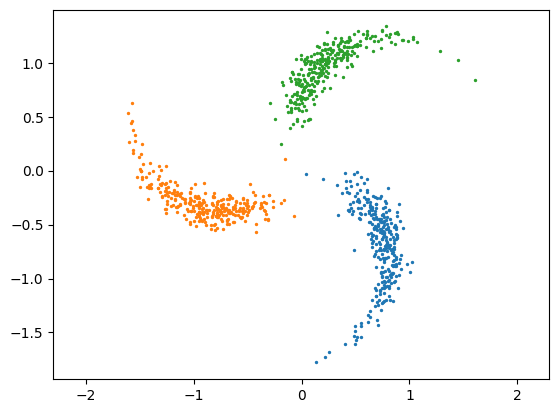

In [ ]:
# Code to generate the pinwheel dataset.
# Taken from [Johnson et al (2016)], updated by Zhao & Linderman.
def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = torch.linspace(0, 2*torch.pi, num_classes + 1)

    features = torch.randn(num_classes*num_per_class, 2) * torch.tensor([radial_std, tangential_std])
    print(features)
    features[:, 0] = features[:, 0] + 1.0
    labels = torch.repeat_interleave(torch.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * torch.exp(features[:,0])
    rotations = torch.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = torch.reshape(rotations.T, (-1, 2, 2))

    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], torch.einsum('ti,tij->tj', features, rotations)[perm_ix]

num_clusters = 3
samples_per_cluster = 300
labels, data = make_pinwheel_data(0.3, 0.1, num_clusters, samples_per_cluster, 0.25)

for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

Implement the missing lines in the below code, to complete the  $\texttt{elbo}$  function for a variational autoencoder.

In [ ]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

#TODO
def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):
    # TODO.  Get posterior parameters
    mean, log_std = recognition_net(data)
    # TODO.  Sample z from approximate posterior.
    z_samples = diag_gaussian_samples(mean, log_std, 1)
    # TODO.  Calculate the joint
    joint_log_prob = log_joint(decoder_net, z_samples, data)
    # TODO.  Calculate the log posterior.
    log_posterior = diag_gaussian_logpdf(z_samples, mean, log_std)
    # TODO.  Produce an unbiased esimate of the ELBO.
    elbo = torch.mean(joint_log_prob - log_posterior)

    return elbo

The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

<ipython-input-64-26fe4ed13568>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  0%|          | 9/2000 [00:00<00:22, 87.77it/s]

Iteration 0 lower bound -62.74226379394531


  6%|▌         | 123/2000 [00:00<00:13, 134.62it/s]

Iteration 100 lower bound -6.7616868019104


 11%|█▏        | 228/2000 [00:01<00:12, 144.21it/s]

Iteration 200 lower bound -2.4071364402770996


 16%|█▌        | 320/2000 [00:02<00:12, 138.76it/s]

Iteration 300 lower bound -2.1184139251708984


 21%|██▏       | 425/2000 [00:03<00:10, 145.17it/s]

Iteration 400 lower bound -1.3300756216049194


 26%|██▌       | 515/2000 [00:03<00:10, 139.90it/s]

Iteration 500 lower bound -2.6995110511779785


 31%|███       | 618/2000 [00:04<00:09, 138.22it/s]

Iteration 600 lower bound -2.145644426345825


 36%|███▌      | 722/2000 [00:05<00:08, 146.35it/s]

Iteration 700 lower bound -2.560523271560669


 41%|████▏     | 827/2000 [00:05<00:08, 146.10it/s]

Iteration 800 lower bound -1.9484561681747437


 46%|████▌     | 918/2000 [00:06<00:07, 143.76it/s]

Iteration 900 lower bound -1.4137407541275024


 51%|█████     | 1019/2000 [00:07<00:10, 98.08it/s]

Iteration 1000 lower bound -2.089232921600342


 56%|█████▌    | 1110/2000 [00:08<00:09, 92.16it/s]

Iteration 1100 lower bound -2.1111021041870117


 61%|██████    | 1222/2000 [00:09<00:06, 122.00it/s]

Iteration 1200 lower bound -2.745434522628784


 66%|██████▋   | 1326/2000 [00:10<00:06, 109.50it/s]

Iteration 1300 lower bound -3.0102193355560303


 71%|███████▏  | 1426/2000 [00:11<00:04, 135.98it/s]

Iteration 1400 lower bound -2.1587295532226562


 76%|███████▌  | 1516/2000 [00:11<00:03, 141.35it/s]

Iteration 1500 lower bound -2.593367576599121


 81%|████████  | 1620/2000 [00:12<00:02, 134.44it/s]

Iteration 1600 lower bound -1.821231484413147


 86%|████████▌ | 1718/2000 [00:13<00:02, 132.25it/s]

Iteration 1700 lower bound -2.207122564315796


 91%|█████████ | 1820/2000 [00:14<00:01, 137.06it/s]

Iteration 1800 lower bound -2.377638339996338


 96%|█████████▌| 1922/2000 [00:14<00:00, 133.70it/s]

Iteration 1900 lower bound -1.766194462776184


100%|██████████| 2000/2000 [00:15<00:00, 129.23it/s]


torch.Size([300, 2])
torch.Size([300, 2])
torch.Size([300, 2])


Text(0, 0.5, 'latent dimension 2')

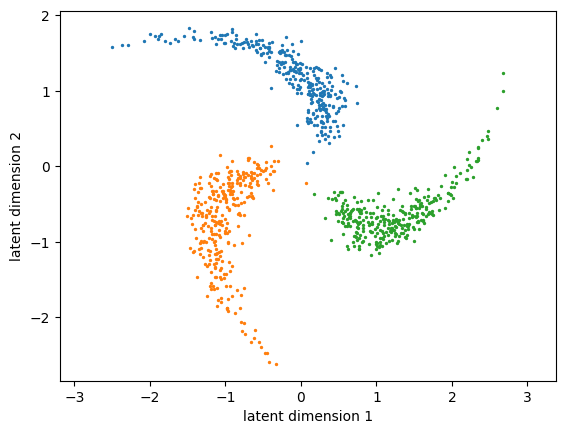

In [ ]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
    cur_data = data[labels == k] # TODO get all the data from this cluster.
    mean, _ = recognition_net(cur_data)

    transformed = mean.detach() # TODO find the mean of q(z|x) for each x. Remember to .detach() any tensors

    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
    print(transformed.shape)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

(-2.0459790349006655,
 1.7035639405250549,
 -1.7973662734031677,
 1.8113139986991882)

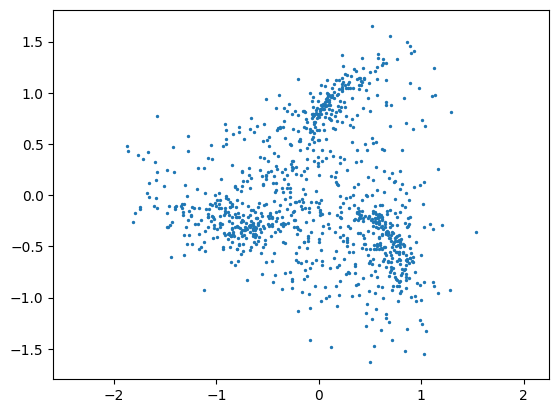

In [ ]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1000

samples = torch.randn(num_samples, latent_dimension)

mean, _ = decoder_net(samples)
transformed = mean.detach()

plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
plt.axis("equal")

Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

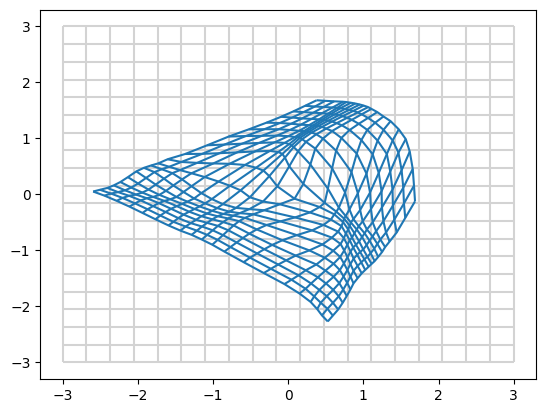

In [ ]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



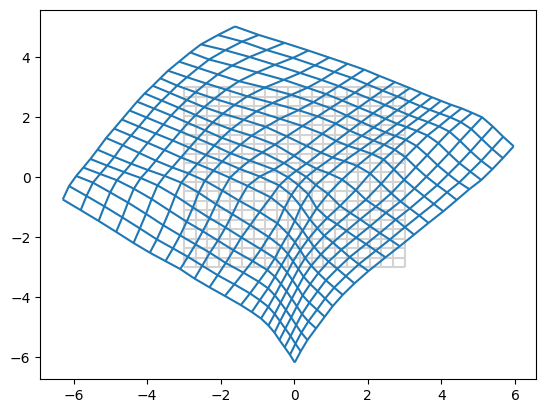

In [ ]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

# [50pts] Question 2: Expectation-Maximization (EM) algorithm

In [ ]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 3.1 [8pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = N(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [ ]:
num_samples = 200
cov = np.array([[10, 7], [7, 10]])
mean_1 = np.array([0.1, 0.1])
mean_2 = np.array([6.0, 0.1])

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples)
xy_class1 = np.append(x_class1, np.ones((num_samples, 1)), axis=1)
xy_class2 =  np.append(x_class2, np.zeros((num_samples, 1)), axis=1)

data_full = np.row_stack([xy_class1, xy_class2])
np.random.shuffle(data_full)
data = data_full[:, :2]
labels = data_full[:, 2]

**b) [3pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

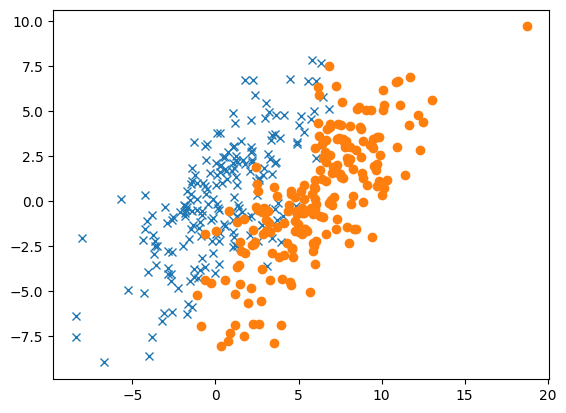

In [ ]:
plt.plot(x_class1[:,0], x_class1[:,1], 'x') # first class, x shape
plt.plot(x_class2[:,0], x_class2[:,1], 'o')  # second class, circle shape

## 3.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat{\mu}_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat{\mu}_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error.

**a) [3pts]** Complete the `cost` function.

In [ ]:
def cost(data, R, Mu):
    """ Compute the K-Means cost function

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
        R: an NxK matrix of responsibilities (assignments)

    Returns:
        J: the K-Means cost
    """

    N, D = data.shape
    K = Mu.shape[1]
    # TODO
    J = 0
    for k in range(K):
      J += np.sum(R[:, k] * np.sum((data - Mu[:, k]) ** 2, axis = 1))

    return J

**b) [4pts]** K-Means assignment step.

In [ ]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations

    Returns:
        R_new: an NxK matrix of responsibilities
    """

    N, D = data.shape
    K = Mu.shape[1]
    r = np.zeros((N,K))
    # TODO assign all r[:, k]
    for k in range(K):
      r[:, k] = np.sum((data - Mu[:, k]) ** 2, axis = 1)

    arg_min = np.argmin(r, axis = 1)  # TODO: argmax/argmin along dimension 1
    R_new = np.zeros((N, K)) # TODO: Set to zeros/ones with shape (N, K)
    R_new[range(N), arg_min] = 1 # TODO Assign to 1
    return R_new

**c) [3pts]** K-Means refitting step.

In [ ]:
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.

    Args:
        data: an NxD matrix for the data points
        R: an NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations

    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """

    N, D = data.shape
    K = Mu.shape[1]
    Mu_new = np.zeros([D, K])
    for k in range(K):
      Mu_new[:, k] = np.sum(R[:, k].reshape(N, 1) * data, axis=0) / np.sum(R[:, k])
    return Mu_new

**d) [3pts]** Run this cell to call the K-Means algorithm.

In [ ]:
N, D = data.shape
K = 2
max_iter = 100
class_init = np.append(np.zeros(num_samples), np.ones(num_samples), axis = 0)
R = np.concatenate((class_init.reshape(N, 1), (1 - class_init).reshape(N, 1)), axis=1)

Mu = np.zeros([D, K])
Mu[:, 1] = 1.
R.T.dot(data), np.sum(R, axis=0)

costs = list()
for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    # print(it, cost(data, R, Mu))
    costs.append(cost(data, R, Mu))

class_1 = data[np.where(R[:, 0])]
class_2 = data[np.where(R[:, 1])]

Text(0.5, 1.0, 'Cost of K-means algorithm over number of iterations')

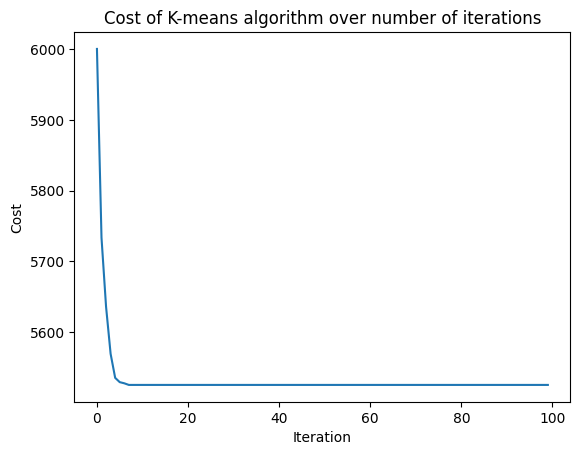

In [ ]:
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.title('Cost of K-means algorithm over number of iterations')

**e) [1pt]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


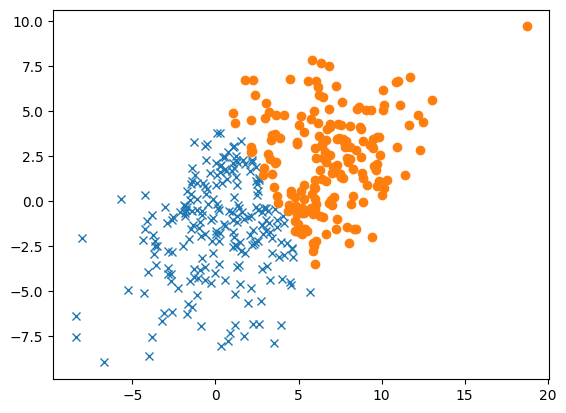

In [ ]:
plt.plot(class_1[:, 0], class_1[:, 1], 'x') # TODO first class, x shape
plt.plot(class_2[:, 0], class_2[:, 1], 'o') # TODO second class, circle shape

## 3.3 [19pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [ ]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [ ]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients

    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """

    N, D = data.shape
    K = Mu.shape[1]
    L, T = 0., 0.
    # TODO: given n, k, compute the likelihood from the k-th Gaussian weighted by the mixing coefficients
    for n in range(N):
      for k in range(K):
        T += Pi[k] * normal_density(data[n], Mu[:, k], Sigma[k])
      L += np.log(T)
      T = 0

    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [ ]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients

    Returns:
        Gamma: an NxK matrix of responsibilities
    """

    N, D = data.shape
    K = Mu.shape[1]
    Gamma = np.zeros([N, K])

    # TODO: given n, k, normalize by sum across second dimension (mixtures)
    for n in range(N):
      for k in range(K):
        Gamma[n, k] = Pi[k] * normal_density(data[n], Mu[:, k], Sigma[k])
      Gamma[n, :] /= np.sum(Gamma[n,:])

    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [ ]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: an NxD matrix for the data points
        Gamma: an NxK matrix of responsibilities

    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """

    N, D = data.shape
    K = Gamma.shape[1]
    Nk = np.sum(Gamma, axis = 0) # TODO Sum along first axis
    Mu = np.zeros([D, K]) # TODO
    Sigma = list() # TODO

    for k in range(K):
      Mu[:, k] = np.sum(Gamma[:, k].reshape(N, 1) * data, axis = 0) / Nk[k]
      # TODO: fill in Sigma[k] for each k
      Sigma.append(np.dot(Gamma[:, k] * (data - Mu[:, k]).T, data - Mu[:, k])
      / Nk[k])

    Pi = Nk / N # TODO
    return Mu, np.array(Sigma), Pi

**d) [3pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [ ]:
N, D = data.shape
K = 2
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities

max_iter  = 200

log_l = list()
for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi)
    Mu, Sigma, Pi = gm_m_step(data, Gamma)
    log_l.append(log_likelihood(data, Mu, Sigma, Pi))

class_1 = data[np.where(Gamma[:, 0] >= 0.5)]
class_2 = data[np.where(Gamma[:, 1] >= 0.5)]

Text(0.5, 1.0, 'Log likelihood of EM algorithm over number of iterations')

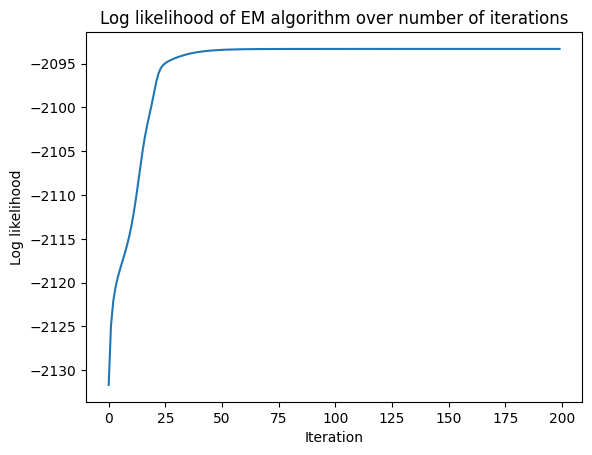

In [ ]:
plt.plot(log_l)
plt.ylabel('Log likelihood')
plt.xlabel('Iteration')
plt.title('Log likelihood of EM algorithm over number of iterations')

**e) [1pt]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

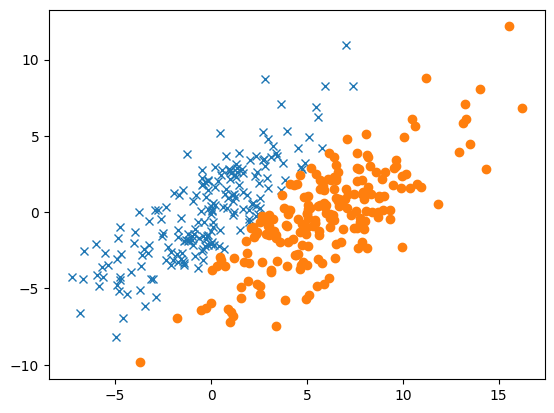

In [ ]:
plt.plot(class_1[:, 0], class_1[:, 1], 'x') # TODO first class, x shape
plt.plot(class_2[:, 0], class_2[:, 1], 'o') # TODO second class, circle shape

## 3.4 [9pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]



Your answer here.

(1). Based on the graphs that show the Gaussian Mixture cluster assignments of each point for the two algorithms, we can see that the EM algorithm had a higher accuracy in capturing the original data generating process compared to k-mean. As the k-mean algorithm performs data points assignments by minimizing distances to means, it is more likely to be affected by the inital assignment of means compared to the EM algorithms, which yielded less accurate results.

(2). The k-mean algorithm converged at around 10 iterations, which was faster than the EM algorithm that converged at about 30 iterations. The runtime of EM is longer than that of k-mean, so it may be harder for the EM algorithm to generalize to data with larger size and dimensions. The bottleneck for k-mean would be that it performs less optimally in capturing the true data generating process due to its implementation.

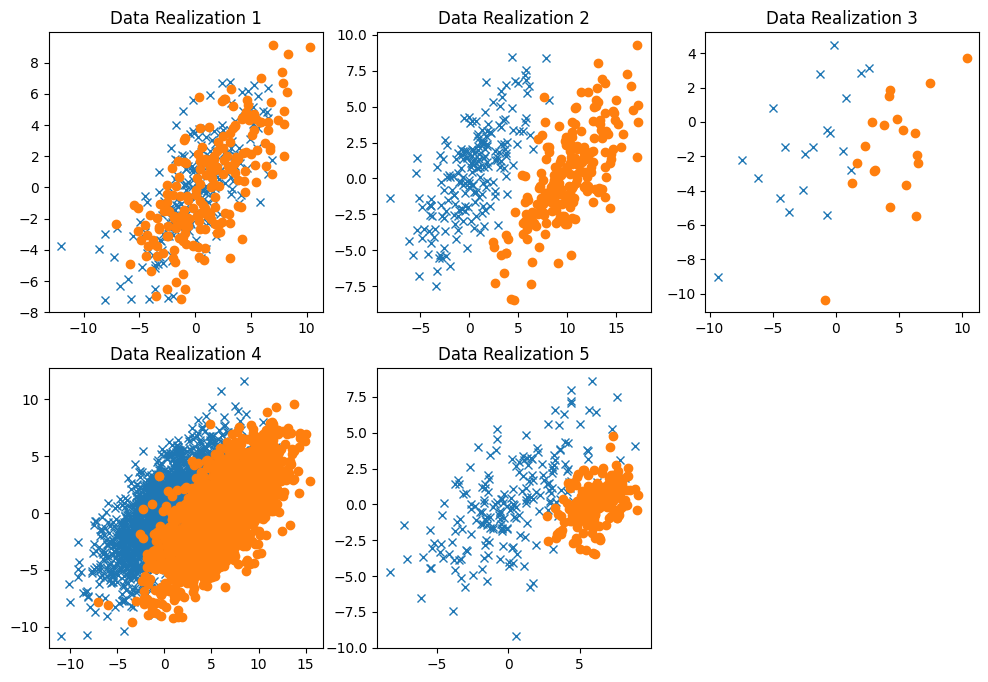

In [ ]:
# (3). Code Part

# Generate five different data realizations

# Realization 1: Similar distributions (mean close together, same covariance)
num_samples = 200
cov = np.array([[10, 7], [7, 10]])
d_1_mean_1 = np.array([0.1, 0.1])
d_1_mean_2 = np.array([1.0, 0.1])

d_1_x_class1 = np.random.multivariate_normal(d_1_mean_1, cov, num_samples)
d_1_x_class2 = np.random.multivariate_normal(d_1_mean_2, cov, num_samples)
d_1_xy_class1 = np.append(d_1_x_class1, np.ones((num_samples, 1)), axis=1)
d_1_xy_class2 =  np.append(d_1_x_class2, np.zeros((num_samples, 1)), axis=1)

d_1_data_full = np.row_stack([d_1_xy_class1, d_1_xy_class2])
np.random.shuffle(d_1_data_full)
d_1_data = d_1_data_full[:, :2]
d_1_labels = d_1_data_full[:, 2]

# Realization 2: Distinct distributions (mean further apart, same covariance)
num_samples = 200
cov = np.array([[10, 7], [7, 10]])
d_2_mean_1 = np.array([0.1, 0.1])
d_2_mean_2 = np.array([10.1, 0.1])

d_2_x_class1 = np.random.multivariate_normal(d_2_mean_1, cov, num_samples)
d_2_x_class2 = np.random.multivariate_normal(d_2_mean_2, cov, num_samples)
d_2_xy_class1 = np.append(d_2_x_class1, np.ones((num_samples, 1)), axis=1)
d_2_xy_class2 =  np.append(d_2_x_class2, np.zeros((num_samples, 1)), axis=1)

d_2_data_full = np.row_stack([d_2_xy_class1, d_2_xy_class2])
np.random.shuffle(d_2_data_full)
d_2_data = d_2_data_full[:, :2]
d_2_labels = d_2_data_full[:, 2]


# Realization 3: Small sample size
num_samples = 20
cov = np.array([[10, 7], [7, 10]])
d_3_mean_1 = np.array([0.1, 0.1])
d_3_mean_2 = np.array([6, 0.1])

d_3_x_class1 = np.random.multivariate_normal(d_3_mean_1, cov, num_samples)
d_3_x_class2 = np.random.multivariate_normal(d_3_mean_2, cov, num_samples)
d_3_xy_class1 = np.append(d_3_x_class1, np.ones((num_samples, 1)), axis=1)
d_3_xy_class2 =  np.append(d_3_x_class2, np.zeros((num_samples, 1)), axis=1)

d_3_data_full = np.row_stack([d_3_xy_class1, d_3_xy_class2])
np.random.shuffle(d_3_data_full)
d_3_data = d_3_data_full[:, :2]
d_3_labels = d_3_data_full[:, 2]


# Realization 4: Large sample size
num_samples = 2000
cov = np.array([[10, 7], [7, 10]])
d_4_mean_1 = np.array([0.1, 0.1])
d_4_mean_2 = np.array([6, 0.1])

d_4_x_class1 = np.random.multivariate_normal(d_4_mean_1, cov, num_samples)
d_4_x_class2 = np.random.multivariate_normal(d_4_mean_2, cov, num_samples)
d_4_xy_class1 = np.append(d_4_x_class1, np.ones((num_samples, 1)), axis=1)
d_4_xy_class2 =  np.append(d_4_x_class2, np.zeros((num_samples, 1)), axis=1)

d_4_data_full = np.row_stack([d_4_xy_class1, d_4_xy_class2])
np.random.shuffle(d_4_data_full)
d_4_data = d_4_data_full[:, :2]
d_4_labels = d_4_data_full[:, 2]


# Realization 5: Distribution with different spread (disinct covariance)
num_samples = 200
cov_1 = np.array([[10, 7], [7, 10]])
cov_2 = np.array([[2, 1], [1, 2]])
d_5_mean_1 = np.array([0.1, 0.1])
d_5_mean_2 = np.array([6, 0.1])

d_5_x_class1 = np.random.multivariate_normal(d_5_mean_1, cov_1, num_samples)
d_5_x_class2 = np.random.multivariate_normal(d_5_mean_2, cov_2, num_samples)
d_5_xy_class1 = np.append(d_5_x_class1, np.ones((num_samples, 1)), axis=1)
d_5_xy_class2 =  np.append(d_5_x_class2, np.zeros((num_samples, 1)), axis=1)

d_5_data_full = np.row_stack([d_5_xy_class1, d_5_xy_class2])
np.random.shuffle(d_4_data_full)
d_5_data = d_5_data_full[:, :2]
d_5_labels = d_5_data_full[:, 2]


# Combine all data
data_lst = [(d_1_x_class1, d_1_x_class2), (d_2_x_class1, d_2_x_class2),
 (d_3_x_class1, d_3_x_class2), (d_4_x_class1, d_4_x_class2), (d_5_x_class1, d_5_x_class2)]


# Create a figure
fig = plt.figure(figsize=(12, 8))

for i in range(5):
  dat = data_lst[i]
  ax = fig.add_subplot(2, 3, i+1)
  ax.plot(dat[0][:,0], dat[0][:,1], 'x')
  ax.plot(dat[1][:,0], dat[1][:,1], 'o')
  ax.set_title(f'Data Realization {i + 1}')

In [ ]:
# K-mean and EM-algorithm functions
def K_mean_algo(data, ax, plot_cost = False, plot_assign = False):
  N, D = data.shape
  K = 2
  max_iter = 100
  class_init = np.append(np.zeros(N // 2), np.ones(N // 2), axis = 0)
  R = np.concatenate((class_init.reshape(N, 1), (1 - class_init).reshape(N, 1)), axis=1)

  Mu = np.zeros([D, K])
  Mu[:, 1] = 1.
  R.T.dot(data), np.sum(R, axis=0)

  costs = list()
  for it in range(max_iter):
      R = km_assignment_step(data, Mu)
      Mu = km_refitting_step(data, R, Mu)
      # print(it, cost(data, R, Mu))
      costs.append(cost(data, R, Mu))

  class_1 = data[np.where(R[:, 0])]
  class_2 = data[np.where(R[:, 1])]

  # Plot cost
  if plot_cost:
    ax.plot(costs)

  # Plot data point assignment
  if plot_assign:
    ax.plot(class_1[:, 0], class_1[:, 1], 'x') # TODO first class, x shape
    ax.plot(class_2[:, 0], class_2[:, 1], 'o') # TODO second class, circle shape


def EM_algo(data, ax, plot_log_like = False, plot_assign = False):
  N, D = data.shape
  K = 2
  Mu = np.zeros([D, K])
  Mu[:, 1] = 1.
  Sigma = [np.eye(2), np.eye(2)]
  Pi = np.ones(K) / K
  Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities

  max_iter  = 200

  log_l = list()
  for it in range(max_iter):
      Gamma = gm_e_step(data, Mu, Sigma, Pi)
      Mu, Sigma, Pi = gm_m_step(data, Gamma)
      log_l.append(log_likelihood(data, Mu, Sigma, Pi))

  class_1 = data[np.where(Gamma[:, 0] >= 0.5)]
  class_2 = data[np.where(Gamma[:, 1] >= 0.5)]

  if plot_log_like:
    ax.plot(log_l)
    # plt.ylabel('Log likelihood')
    # plt.xlabel('Iteration')
    # plt.title('Log likelihood of EM algorithm over number of iterations')

  if plot_assign:
    plt.plot(class_1[:, 0], class_1[:, 1], 'x') # TODO first class, x shape
    plt.plot(class_2[:, 0], class_2[:, 1], 'o') # TODO second class, circle shape


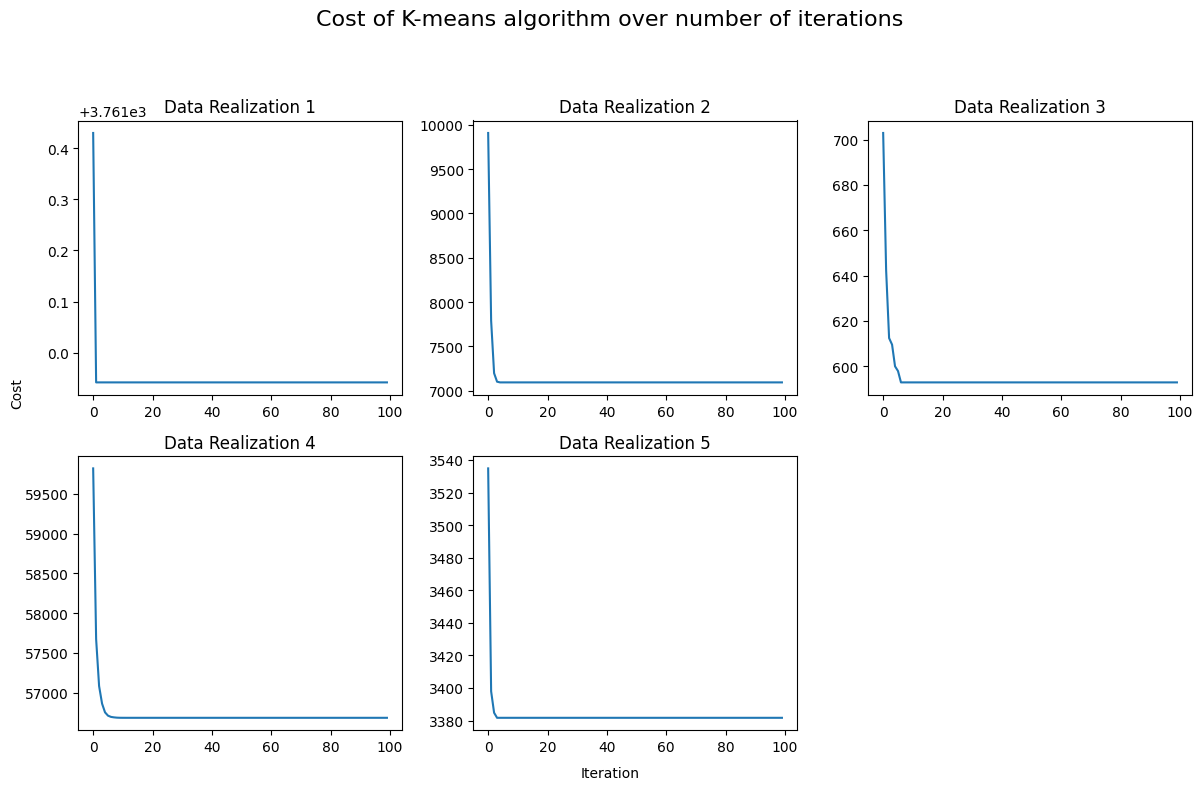

In [ ]:
full_data_lst = [d_1_data, d_2_data, d_3_data, d_4_data, d_5_data]

# Create a figure for costs of k means
fig = plt.figure(figsize=(12, 8))

for i in range(5):
  data = full_data_lst[i]
  ax = fig.add_subplot(2, 3, i+1)
  K_mean_algo(data, ax, plot_cost = True)
  ax.set_title(f'Data Realization {i + 1}')


# Add overall x and y axis labels
fig.text(0.5, 0.02, 'Iteration', ha='center')
fig.text(0.0001, 0.5, 'Cost', va='center', rotation='vertical')

# Add a title for the entire set of plots
fig.suptitle('Cost of K-means algorithm over number of iterations', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the position of the main title
plt.show()

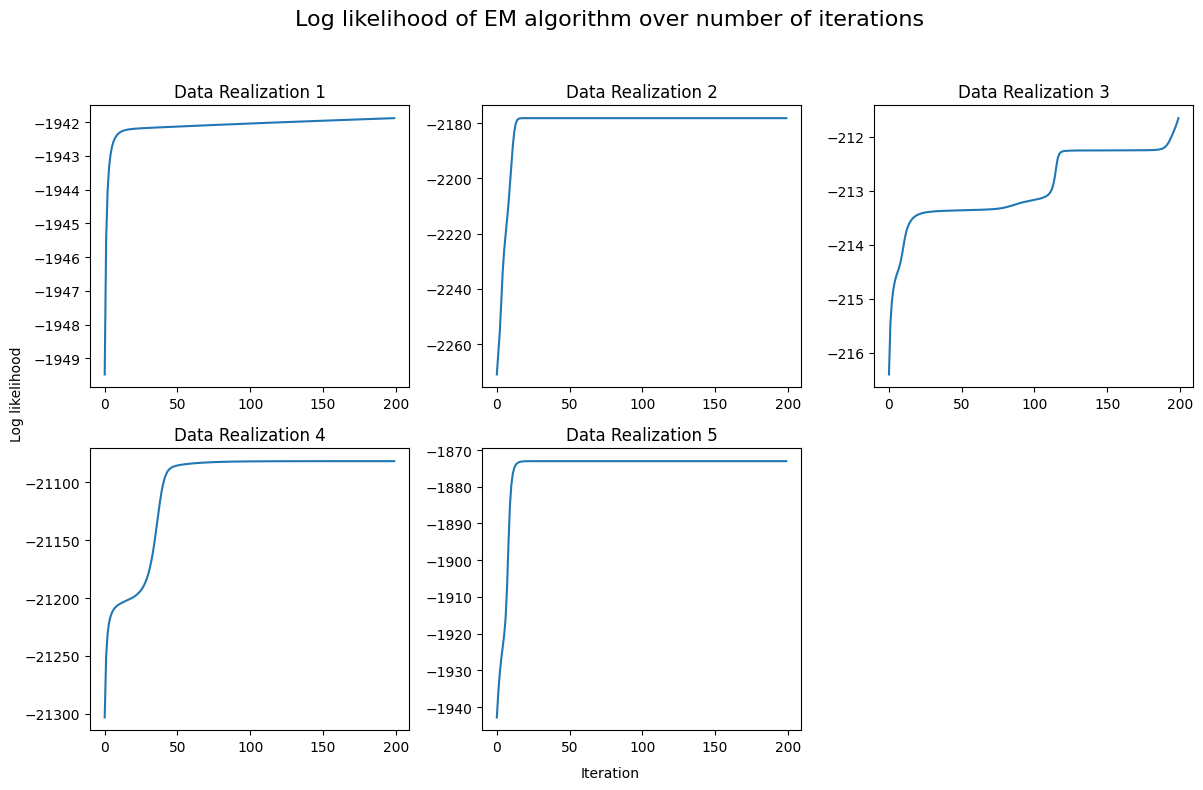

In [ ]:
# Create a figure for log likelihood of EM
fig = plt.figure(figsize=(12, 8))

for i in range(5):
  data = full_data_lst[i]
  ax = fig.add_subplot(2, 3, i+1)
  EM_algo(data, ax, plot_log_like = True)
  ax.set_title(f'Data Realization {i + 1}')


# Add overall x and y axis labels
fig.text(0.5, 0.02, 'Iteration', ha='center')
fig.text(0.0001, 0.5, 'Log likelihood', va='center', rotation='vertical')

# Add a title for the entire set of plots
fig.suptitle('Log likelihood of EM algorithm over number of iterations', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the position of the main title
plt.show()

(3a). The convergence rate and the runtime of the K-mean algorithm across five different data realizations is still faster compared to that of the EM algorithm. However, the convergence rate also differs for different realizations. The k-mean algorithm converges very fast if the data were generated from similar distributions. When the sample size is very small (realization 3), it is harder for the EM algorithm to converge, as we can see that the algorithm may need more than 200 iterations to converge.

Therefore, we can conclude that the algorithm convergence depends on different realizations of data based on the plots.


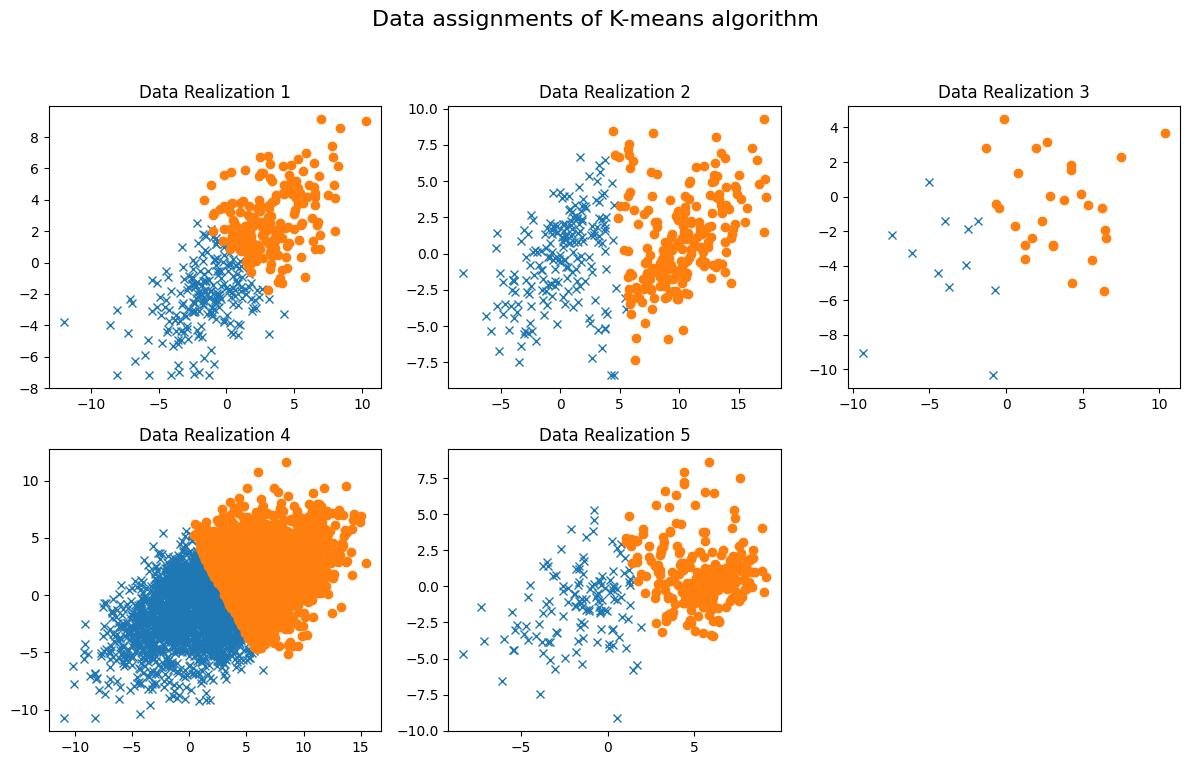

In [ ]:
# Create a figure for data assignments of k means
fig = plt.figure(figsize=(12, 8))

for i in range(5):
  data = full_data_lst[i]
  ax = fig.add_subplot(2, 3, i+1)
  K_mean_algo(data, ax, plot_assign = True)
  ax.set_title(f'Data Realization {i + 1}')

# Add a title for the entire set of plots
fig.suptitle('Data assignments of K-means algorithm', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the position of the main title
plt.show()

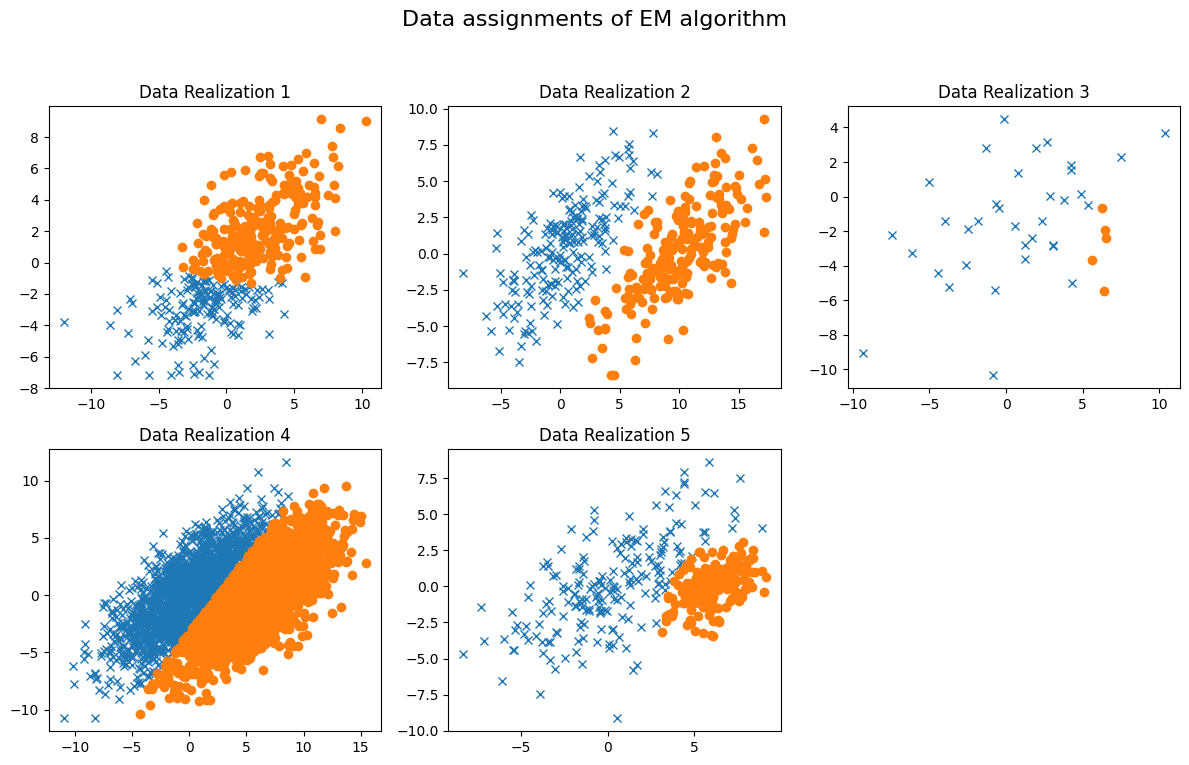

In [ ]:
# Create a figure for data assignments of EM
fig = plt.figure(figsize=(12, 8))

for i in range(5):
  data = full_data_lst[i]
  ax = fig.add_subplot(2, 3, i+1)
  EM_algo(data, ax, plot_assign = True)
  ax.set_title(f'Data Realization {i + 1}')


# Add a title for the entire set of plots
fig.suptitle('Data assignments of EM algorithm', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the position of the main title
plt.show()

(3b). In terms of data assignment, the two algorithms also follows a similar trend to the original data realization that the EM algorithm showed more accurate results than the K-mean. It is worth noticing that when two distributions are more distinct (realization 2), the k-mean algorithm might be less affected and demonstrated a similar assignment to the true data. When two distributions are very similar (realization 1), the EM algorithm also exhibited less optimal results.

Moreover, the EM algorithm was able to capture the difference in covariance structure between distributions (realization 5), while k-mean could not achieve this. There seems to be more misclassification for the EM algorithm than the K-mean when the sample size is small (realization 3), but this may also due to the fact that the EM algorithm did not converge.

Overall, we can conclude that data realizations would affect the model performance.

(4). Increase the number of clusters k may potentially decrease the misclassification rate given more flexibility in the algorithm.